Variational Autoencoder (VAE) for Image Generation with Fashion MNIST
This is a complete step-by-step guide to implementing a Variational Autoencoder (VAE) for image generation using the Fashion MNIST dataset. The code is designed to run in Google Colab.

Set Up Google Colab Environment

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Enable GPU acceleration (if available)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

TensorFlow version: 2.18.0
Found GPU at: /device:GPU:0


 Load and Preprocess the Fashion MNIST Dataset

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


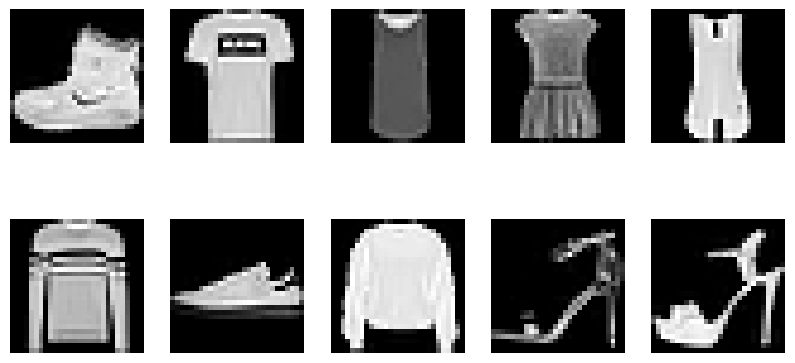

In [2]:
# Load Fashion MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Preprocess the data
def preprocess(images):
    images = images.astype('float32') / 255.0
    images = np.expand_dims(images, -1)  # Add channel dimension
    return images

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Dataset parameters
image_size = x_train.shape[1:]
input_dim = np.prod(image_size)
batch_size = 128
latent_dim = 2  # For easy visualization

# Create tf.data.Dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.batch(batch_size)

# Display sample images
plt.figure(figsize=(10, 5))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

Build the VAE Model

In [3]:
# Sampling layer for latent space
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder architecture
def build_encoder(input_shape, latent_dim):
    encoder_inputs = keras.Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)

    # Output mean and log variance
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    # Sampling layer
    z = Sampling()([z_mean, z_log_var])

    # Build encoder model
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

# Decoder architecture
def build_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))

    # Dense and reshape
    x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)

    # Transposed convolutional layers
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

    # Output layer
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    # Build decoder model
    decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
    return decoder

# VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Compute losses
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Build and compile the VAE
encoder = build_encoder(image_size, latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

Train the VAE Model

In [6]:
# Training parameters
epochs = 30

# Train the model
# VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Compute losses
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Visualize Results

Generated Images:


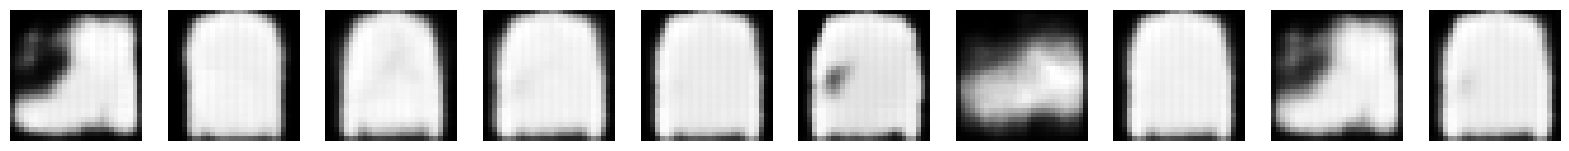

Latent Space Clusters:


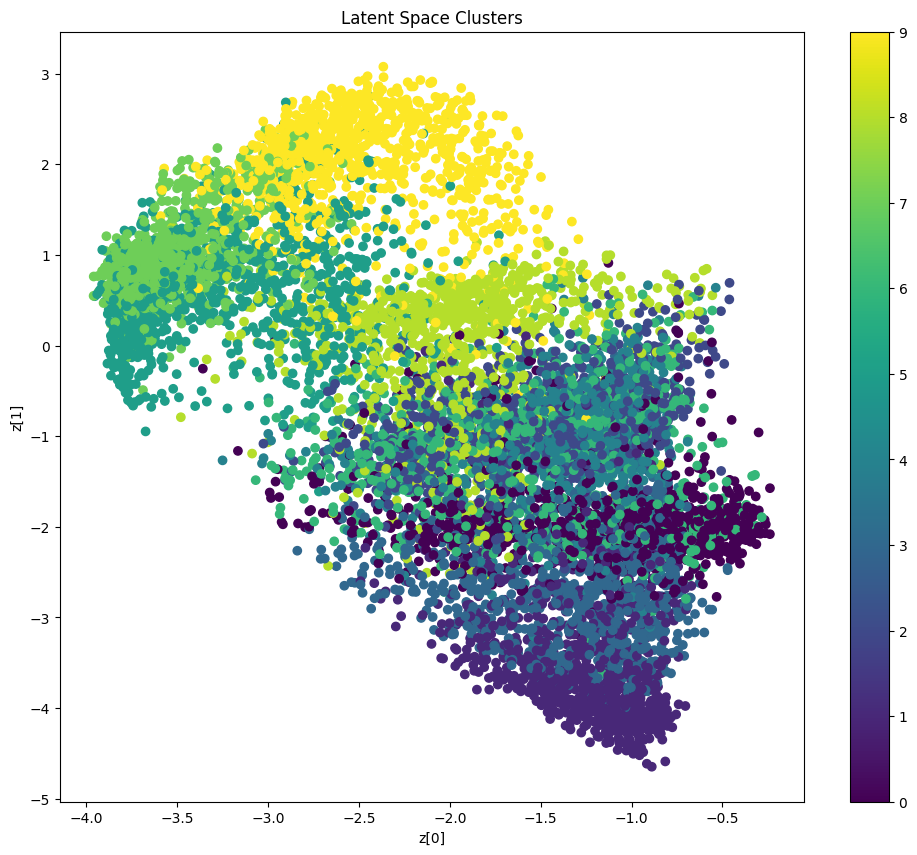

2D Latent Space Manifold:


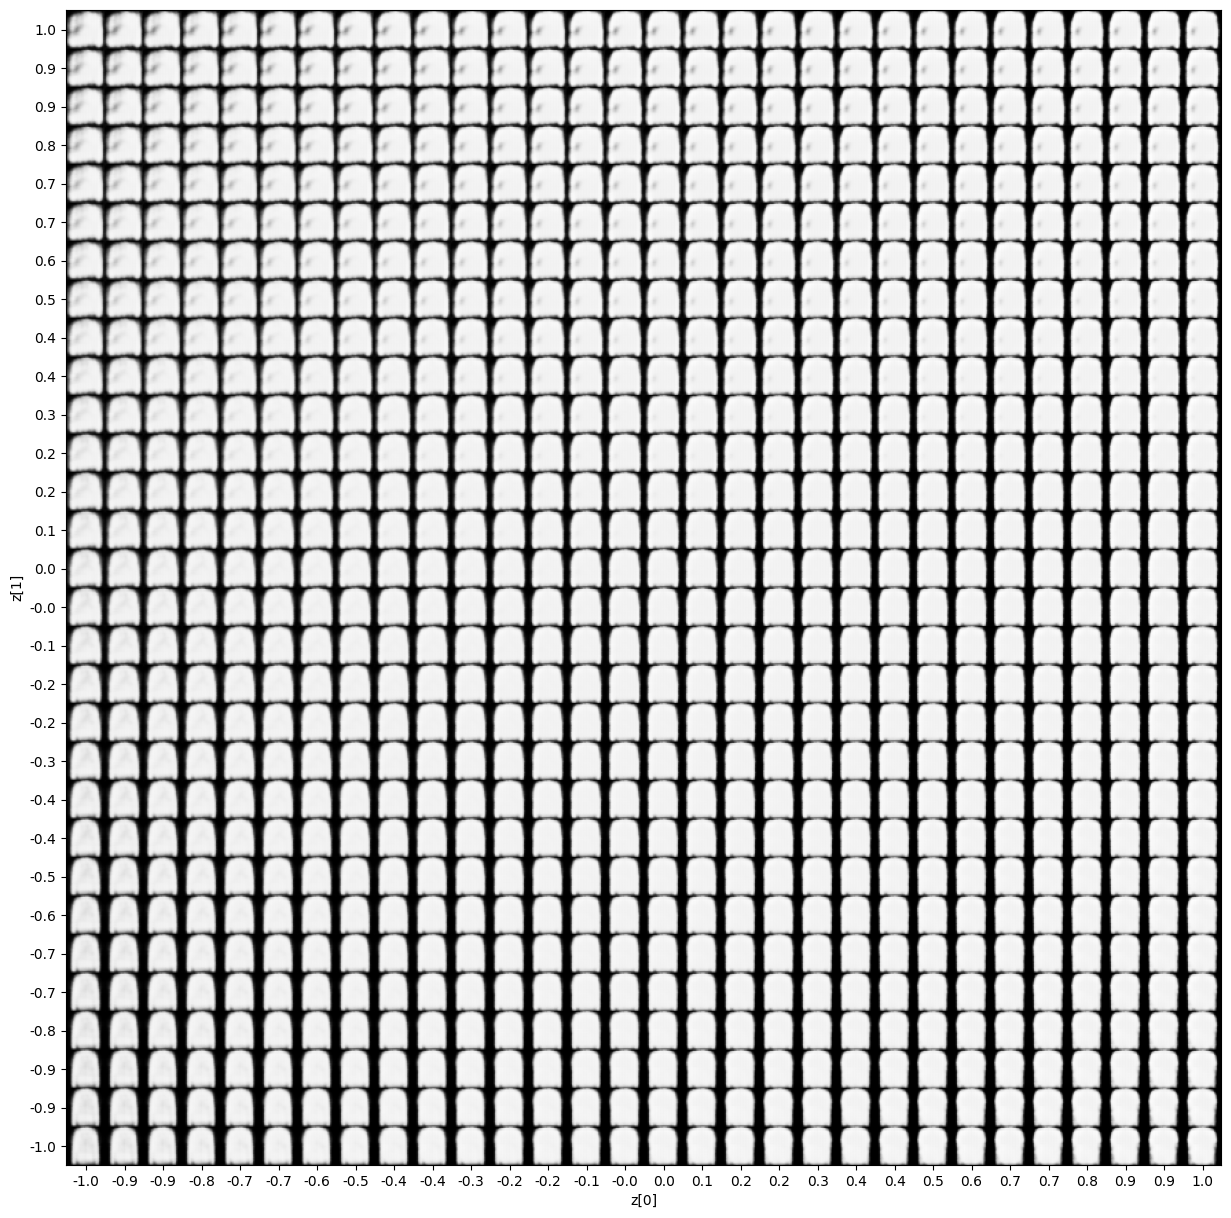

In [7]:
# Function to display a grid of generated images
def plot_latent_space(vae, n=30, figsize=15):
    # Display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))

    # Linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

# Function to plot label clusters in latent space
def plot_label_clusters(vae, data, labels):
    # Display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space Clusters")
    plt.show()

# Generate and display some images
def generate_and_display(vae, num_images=10):
    random_latent_vectors = np.random.normal(size=(num_images, latent_dim))
    generated_images = vae.decoder.predict(random_latent_vectors, verbose=0)

    plt.figure(figsize=(20, 2))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Load labels for visualization
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()

# Visualize results
print("Generated Images:")
generate_and_display(vae)

print("Latent Space Clusters:")
plot_label_clusters(vae, x_test, y_test)

print("2D Latent Space Manifold:")
plot_latent_space(vae)

Save and Load the Model

In [9]:
# Step 6: Save and Load the Model

# Save the entire model
save_dir = "/content/saved_models"
os.makedirs(save_dir, exist_ok=True)

# Option 1: Save in the new .keras format (recommended)
model_path = os.path.join(save_dir, "fashion_mnist_vae.keras")
vae.save(model_path)
print(f"Model saved to {model_path}")

# To load the model later:
# loaded_vae = keras.models.load_model(model_path, custom_objects={'Sampling': Sampling})

Model saved to /content/saved_models/fashion_mnist_vae.keras
